# Chapter 6
> FastBook Chapter 6 Multi-Label Classification, In this notebook I followed both Jeremy Howard\'s Lesson on fast.ai and Weigh and Biases reading group videos. Lots of notes added. .Click `open in colab` button at the right side to view as notebook.

- toc: true 
- badges: true
- comments: true
- categories: [fastbook]
- image: images/fastbook.jpeg

![](images/chapter-06/fastbook.jpeg)
My `Deep Learning for Coders with fastai & PyTorch` has arrived. It is very good for taking notes on it directly. (Some chapters are slightly different from notebook versions)

In [1]:

#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *

# Other Computer Vision Problems

## Multi-Label Classification
I think main theme of this lesson is "Binary Cross Entropy". It is important when e.g. a photo have more than one category or when there is nothing in it. Think about the Bear classifier. I classifies between two. But if there is an another bear breed in the picture it just tries to pick either black or grizzlie anyway which is not good, or if there is one grizzlie and one rabbit. It would be probably confused between these labels, at least its confidence level would be lower.

### The Data

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


> Note: pd at the beginning is `pandas` it is library for creating data frames `df` from csv files. Data frame is a table contains columns and rows.  there are some rows that contains more than one labels. Check row no 2.

### Sidebar: Pandas and DataFrames

In [5]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

> Note: Very easy to navigate in a dataframe.

In [6]:
df.iloc[0,:]
# Trailing :s are always optional (in numpy, pytorch, pandas, etc.),
#   so this is equivalent:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [7]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

> Note: it is possible to use column names to select a column in the dataframe.

In [8]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


In [9]:
tmp_df['c'] = tmp_df['a']+tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


> Note: It is also possible to create new column.

> Note: From the book:

Pandas is a fast and flexible library, and an important part of every data scientist’s Python toolbox. Unfortunately, its API can be rather confusing and surprising, so it takes a while to get familiar with it. If you haven’t used Pandas before, we’d suggest going through a tutorial; we are particularly fond of the book [*Python for Data Analysis*](http://shop.oreilly.com/product/0636920023784.do) by Wes McKinney, the creator of Pandas (O'Reilly). It also covers other important libraries like `matplotlib` and `numpy`. We will try to briefly describe Pandas functionality we use as we come across it, but will not go into the level of detail of McKinney’s book.

### Constructing a DataBlock

- `Dataset`:: Anything in which index to it and you can take the length to it.
- `DataLoader`:: An iterator that provides a stream of mini-batches, where each mini-batch is a tuple of a batch of independent variables and a batch of dependent variables

In [10]:
a = list (enumerate(string.ascii_lowercase))
a[0],len(a)

((0, 'a'), 26)

> Note: above index and length.

In [11]:
dl_a = DataLoader(a, batch_size=8, shuffle=True)
b = first(dl_a)
b

(tensor([ 7, 24, 17, 21,  5, 19,  9, 15]),
 ('h', 'y', 'r', 'v', 'f', 't', 'j', 'p'))

> Note: `batch_size=8` for mini-batch size. `first` just takes the first batch.

In [12]:
list(zip(b[0],b[1]))

[(tensor(7), 'h'),
 (tensor(24), 'y'),
 (tensor(17), 'r'),
 (tensor(21), 'v'),
 (tensor(5), 'f'),
 (tensor(19), 't'),
 (tensor(9), 'j'),
 (tensor(15), 'p')]

> Note: This is how you can see which independent and dependent variables are correspond each other.

In [13]:
list(zip(*b))

[(tensor(7), 'h'),
 (tensor(24), 'y'),
 (tensor(17), 'r'),
 (tensor(21), 'v'),
 (tensor(5), 'f'),
 (tensor(19), 't'),
 (tensor(9), 'j'),
 (tensor(15), 'p')]

> Note: Short cut for zipping.*try to understand) It used for transposing (JH said in the lesson video, check it how)

- `Datasets`:: An object that contains a training `Dataset` and a validation `Dataset`
- `DataLoaders`:: An object that contains a training `DataLoader` and a validation `DataLoader`

In [14]:
a = list (string.ascii_lowercase)
a[0],len(a)

('a', 26)

similar dataset as previous one. but there is no enumeration.

In [15]:
dss = Datasets(a)
dss[0]

('a',)

For creating our dependent and independent variable we can use functions. e.g.:

In [16]:
def f1 (o): return o+'a'
def f2 (o): return o+'b'

In [17]:
dss = Datasets(a,[[f1]])
dss[0]

('aa',)

In [18]:
dss = Datasets(a,[[f1,f2]])
dss[0]

('aab',)

> Note: that means if we have  'a' in the inital dataset, our independent value should  be 'aa' and our dependent should be 'ab'. But it is not at the moment. `[[f1,f2]])` is a list of lists and if we change the shape of the input arguments a bit:

In [19]:
dss = Datasets(a,[[f1],[f2]])
dss[0]

('aa', 'ab')

> Note: Now we are good to go. Now we can create our `Dataloaders` from our `Datasets`. 

In [20]:
dls = DataLoaders.from_dsets(dss, batch_size=4)

In [21]:
first(dls.train)

(('ra', 'sa', 'ka', 'wa'), ('rb', 'sb', 'kb', 'wb'))

> Note: Our dataloaders are ready. This is how we create dataloaders from scratch.

### What is DataBlock

> Note: There is much more easier way to create our datasets.

In [22]:
dblock = DataBlock()

> Note: An empty  `DataBlock`.

In [23]:
dsets = dblock.datasets(df)

> Note: From the book:


We can create a `Datasets` object from this. The only thing needed is a source—in this case, our DataFrame `df`

In [24]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

Our training and validation sets are ready. How? First: if we didn't give any argument for splitting then the split is random and the split ratio is %20.

In [25]:
x,y = dsets.train[0]
x,y

(fname         002786.jpg
 labels      horse person
 is_valid            True
 Name: 1401, dtype: object,
 fname         002786.jpg
 labels      horse person
 is_valid            True
 Name: 1401, dtype: object)

This is first row of the batch repeated twice. (this is how default works)

In [26]:
x['fname']

'002786.jpg'

> Note: However we need file name (`fname`) as a independent and `labels` as dependent variables.

In [27]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('007204.jpg', 'cat')

> Note: like this.

Same thing with functions without lamda functions. Most of the time it is much more relevant because Lambda couses problems if you wanted to serialize them.

In [28]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002848.jpg', 'motorbike')

In [29]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/home/niyazi/.fastai/data/pascal_2007/train/004010.jpg'),
 ['sofa', 'person'])

> Note all are Ok again. Datasets are ready, the shape is right.

In [30]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

> Note: `blocks` types are important, in previous lessons we used different type of blocks. Based on selected type `Datablock` gains additional capabilities. In the current one `ImageBlock` help us to see the information as image. MultiCategoryBlock encodes labels as a tensor that every index correspond to a object label. (onehot encoding). One think I do not understand about it that how fastai understands number of categories.(total 20 now)

In [38]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
print(idxs)
dsets.train.vocab[idxs]

TensorMultiCategory([ 6, 14])


(#2) ['car','person']

> Note: Example above there are two categories. (it changes every run)

In [51]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

> Note: `~` is a bitwise operation that revers bits.

In [52]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

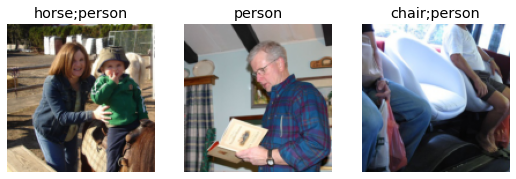

In [53]:
dls.show_batch(nrows=1, ncols=3)

### Binary Cross-Entropy

In [54]:
learn = cnn_learner(dls, resnet18)

/home/niyazi/anaconda3/envs/fastbook/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [55]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

> Note: `model` refers to `resnet` at this statement and `activs` are activation from the last layer of the resnet18 for one batch. Jeremy says 'learn.model(x)' is plain pytorch. (didn't know it)

In [56]:
activs[0]

tensor([ 2.6969, -1.9444,  2.6885, -0.2350, -1.6679,  0.4737,  0.3394, -4.8533,  0.3457,  1.3181, -2.2689, -1.5487,  0.5637,  0.3988,  1.0406, -6.2622,  0.2690,  1.3332, -3.4336, -2.3360],
       grad_fn=<SelectBackward>)

In [57]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

> Note:A couple of things going on here:
- Sigmoid brings everything between and one.
- Log just adjust results such a way based on their relative confidence level. (Check the section on [Chapter -5](https://niyazikemer.com/fastbook/2021/07/22/chapter-5.html#FUNCTION-FOR-CLASSIFIYING-MORE-THAN-TWO-CATEGORY))
- Broadcasting. We'll get the results for every item. 

In [58]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0497, grad_fn=<AliasBackward>)

> Important: Although there is a pytorch equivalent for our `binary_cross_entropy` ( F.binary_cross_entropy and nn.BCELoss) they don't include sigmoid. So instead we use `F.binary_cross_entropy_with_logits` or  `nn.BCEWithLogitsLoss` .

> Note: Direct from the book:

We don't actually need to tell fastai to use this loss function (although we can if we want) since it will be automatically chosen for us. fastai knows that the `DataLoaders` has multiple category labels, so it will use `nn.BCEWithLogitsLoss` by default.

One change compared to the last chapter is the metric we use: because this is a multilabel problem, we can't use the accuracy function. Why is that? Well, accuracy was comparing our outputs to our targets like so:

```python
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred = inp.argmax(dim=axis)
    return (pred == targ).float().mean()
```

The class predicted was the one with the highest activation (this is what `argmax` does). Here it doesn't work because we could have more than one prediction on a single image. After applying the sigmoid to our activations (to make them between 0 and 1), we need to decide which ones are 0s and which ones are 1s by picking a *threshold*. Each value above the threshold will be considered as a 1, and each value lower than the threshold will be considered a 0:

```python
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()
```

> Note: We need the pass our accuracy function to learner for get accuracy. See `learn` statement below. Only one problem default value is .5. When we need an another value we need to use Python `partial` functionality. See usage below or check original file [check original file](https://colab.research.google.com/github/fastai/fastbook/blob/master/06_multicat.ipynb) and video

In [59]:
def say_hello(name, say_what="Hello"): return f"{say_what} {name}."
say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

In [60]:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

In [62]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.944198,0.699985,0.231633,00:11
1,0.820804,0.559335,0.293207,00:10
2,0.598864,0.202987,0.817052,00:11
3,0.360442,0.125777,0.943586,00:11


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.134665,0.116748,0.944383,00:12
1,0.115126,0.107070,0.950319,00:12
2,0.096478,0.103205,0.954761,00:12


In [63]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10320540517568588,0.935438334941864]

> Note: Low threshold (selects even on low confidence)

In [64]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10320540517568588,0.9433068633079529]

> Note: High threshold (selects only on high confidence)

In [65]:
preds,targs = learn.get_preds()

In [68]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9574)

> Note: This a better way to pick the right accuracy value.Trying it.

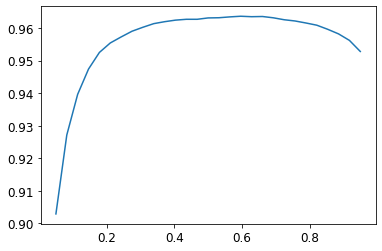

In [67]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

0.5 looks the best.

## Regression

> Note: We can define regression as our dependent variable is not a class but a continous number e.g. house price or a coordinate.

### Assemble the Data

In [69]:
path = untar_data(URLs.BIWI_HEAD_POSE)

> Note: In this exaple we will find center point of a head that given as input.

In [70]:
#hide
Path.BASE_PATH = path

In [74]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [75]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

> Note: From the book:

- Inside the subdirectories, we have different frames, each of them come with an image (*\_rgb.jpg*) and a pose file (*\_pose.txt*). We can easily get all the image files recursively with `get_image_files`, then write a function that converts an image filename to its associated pose file:

In [72]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('03/frame_00668_pose.txt')

`img2pose` creates a path based for coordinate file based on image name.

In [76]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

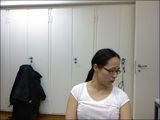

In [77]:
im.to_thumb(160)

In [79]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

> Note: From the book:
- The Biwi dataset website used to explain the format of the pose text file associated with each image, which shows the location of the center of the head. The details of this aren't important for our purposes, so we'll just show the function we use to extract the head center point:

In [80]:
get_ctr(img_files[0])

tensor([447.7369, 283.9802])

In [81]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

> Note: Most important thing about this DataBlock is `splitter`, basically we only use person no 13.[see explanation](https://youtu.be/cX30jxMNBUw?t=4419). Only one person as validation set(of course lots of pics of the person no:13), if we'd split randomly then there would be a very high chance for same person to be in the both training and validations sets. (there are lots of pictures of same person)
Also see dependent variable is continious value which is `PointBlock`.
There is also a normalization process as `batch_tmfs`.

/home/niyazi/anaconda3/envs/fastbook/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


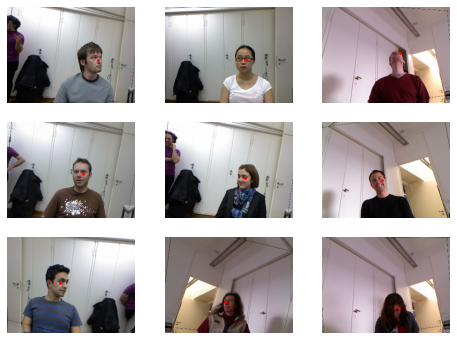

In [82]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [83]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

`(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))` is important. 
- 64     : batch size
- 3      : RGB
- 240,320: image size
- 1,2    : one row with two values (one point with two coordinates)

In [85]:
yb[0]

TensorPoint([[-0.3804,  0.0560]], device='cuda:0')

Dependent variable.

### Training a Model

In [86]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

`y_range=(-1,1)` is important we tell fast ai that we need results in this range.(for coordinates) y_range is implemented in fastai using sigmoid_range, which is defined as:

In [87]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

/home/niyazi/anaconda3/envs/fastbook/lib/python3.8/site-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/RangeFactories.cpp:25.)
  x = torch.linspace(min,max)


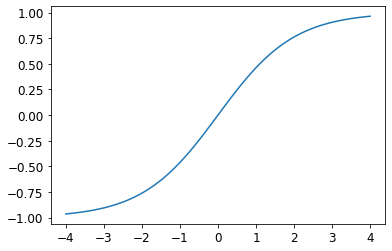

In [88]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [89]:
dls.loss_func

FlattenedLoss of MSELoss()

Default value

/home/niyazi/anaconda3/envs/fastbook/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=tensor(0.0010))

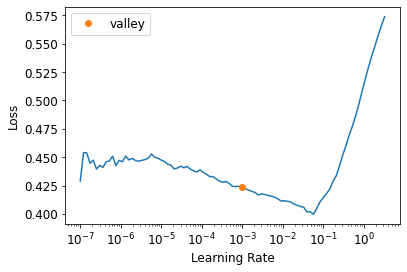

In [90]:
learn.lr_find()

In [91]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.049378,0.025276,00:46


epoch,train_loss,valid_loss,time
0,0.007891,0.004871,00:56
1,0.002884,0.000292,00:53
2,0.001491,0.000217,00:53


In [92]:
math.sqrt(0.0001)

0.01

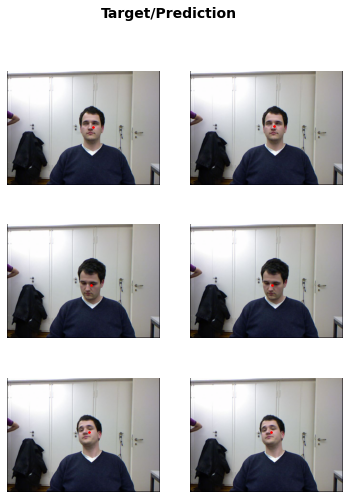

In [93]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

## Conclusion

## Questionnaire

1. How could multi-label classification improve the usability of the bear classifier?
1. How do we encode the dependent variable in a multi-label classification problem?
1. How do you access the rows and columns of a DataFrame as if it was a matrix?
1. How do you get a column by name from a DataFrame?
1. What is the difference between a `Dataset` and `DataLoader`?
1. What does a `Datasets` object normally contain?
1. What does a `DataLoaders` object normally contain?
1. What does `lambda` do in Python?
1. What are the methods to customize how the independent and dependent variables are created with the data block API?
1. Why is softmax not an appropriate output activation function when using a one hot encoded target?
1. Why is `nll_loss` not an appropriate loss function when using a one-hot-encoded target?
1. What is the difference between `nn.BCELoss` and `nn.BCEWithLogitsLoss`?
1. Why can't we use regular accuracy in a multi-label problem?
1. When is it okay to tune a hyperparameter on the validation set?
1. How is `y_range` implemented in fastai? (See if you can implement it yourself and test it without peeking!)
1. What is a regression problem? What loss function should you use for such a problem?
1. What do you need to do to make sure the fastai library applies the same data augmentation to your inputs images and your target point coordinates?

### Further Research

1. Read a tutorial about Pandas DataFrames and experiment with a few methods that look interesting to you. See the book's website for recommended tutorials.
1. Retrain the bear classifier using multi-label classification. See if you can make it work effectively with images that don't contain any bears, including showing that information in the web application. Try an image with two different kinds of bears. Check whether the accuracy on the single-label dataset is impacted using multi-label classification.